In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters

In [2]:
file_path = '/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/resubmission/SI/S3_Instability_accumulation'

In [3]:
doubling_rate = 0.5
doubling_time = 1/doubling_rate
growth_rate = np.log(2) * doubling_rate
alpha=110
n_cycles = 100
t_max = n_cycles / doubling_rate
dt = 0.001
v_0 = 0.5
n_0 = 100
n_crit = 300
t_cc = 2/3
exponent = 0.1

IDA = False
if IDA:
    division_control = 'IDA'
else:
    division_control = 'tcc'
V_d = 1

# specifies whether the production rate is volume dependent and whether it is linear or bilinear
gene_expr = 'volume' # options 'bilinear' or 'linear' or 'volume'

In [4]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)
dark_yellow = (235 / 255, 201 / 255, 27 / 255)

# Functions

In [5]:
def grow_volume(volume, time_step, growth_rate, dt):
    return volume[time_step-1]+ volume[time_step-1] * growth_rate * dt

def produce_proteins(number, time_step, alpha, dt, n_oris):
    return number[time_step-1] + alpha * dt * n_oris[time_step-1]

def produce_proteins_linear(number, time_step, alpha, dt, n_oris):
    return number[time_step-1] + alpha * dt

def produce_proteins_volume(number, volume, time_step, alpha, dt, exponent):
    return number[time_step-1] + alpha * volume[time_step-1]**exponent * dt

# Cell cycle

In [6]:
time = np.arange(0, t_max, dt)
volume = np.ones(time.size) * v_0
n_oris = np.ones(time.size)
number = np.ones(time.size) * n_0

list_next_init = []
list_next_division = []
list_t_init = []
list_t_div = []
list_t_cc = []
list_t_ast = []
list_t_inter_init = []
list_v_init = []
list_v_div = []
next_division = t_max
list_next_division = [t_max]

for time_step in range(0, time.size):
    # update volume, number of initiators and origins of this time step
    n_oris[time_step] = n_oris[time_step-1]
    volume[time_step] = grow_volume(volume, time_step, growth_rate, dt)
    if gene_expr == 'linear':
        number[time_step] = produce_proteins(number, time_step, alpha, dt, n_oris)
    elif gene_expr == 'bilinear':
        number[time_step] = produce_proteins_linear(number, time_step, alpha, dt, n_oris)
    elif gene_expr == 'volume':
        number[time_step] = produce_proteins_volume(number, volume, time_step, alpha, dt, exponent)
    else:
        print('problem, none of the gene expression models applies')
        break
        
    # check whether replication should be initiated, if yes, division time is triggered
    if number[time_step] >= n_crit * n_oris[time_step]:
        n_oris[time_step]= 2 * n_oris[time_step]
#         number[time_step] = 0 
        if len(list_t_init) > 0:
            list_t_inter_init.append(time[time_step]-list_t_init[-1])
        list_v_init.append(volume[time_step])
        list_t_init.append(time[time_step])
        if len(list_t_div) > 0:
            list_t_ast.append(time[time_step]-list_t_div[-1])
        if not IDA:
            t_division = time[time_step] + t_cc
            if list_next_division[0] == t_max:
                list_next_division[0] = t_division
            else:
                list_next_division.append(t_division)
    # check whether cell should divide
    if IDA:
        if volume[time_step] >= V_d:
            volume[time_step] = volume[time_step]/2
            number[time_step] = number[time_step]/2
            n_oris[time_step] = n_oris[time_step]/2
            list_t_div.append(time[time_step])
            list_v_div.append(volume[time_step])
            if len(list_t_init) > 0:
                list_t_cc.append(time[time_step]-list_t_init[-1])
            
    else:
        if time[time_step] >= list_next_division[0]:
            volume[time_step] = volume[time_step]/2
            number[time_step] = number[time_step]/2
            n_oris[time_step] = n_oris[time_step]/2
            list_t_div.append(time[time_step])
            list_v_div.append(volume[time_step])
            if len(list_t_init) > 0:
                list_t_cc.append(time[time_step]-list_t_init[-1])
            list_next_division.pop(0)

        if len(list_next_division)==0:
            list_next_division.append(t_max)

In [12]:
time_interval = np.array(list_t_init)[1:]- np.array(list_t_init)[:-1]
t_ast_th = n_crit/ alpha - (list_t_cc[-1]/2)
t_ast_th_2 = (n_crit/2 - alpha * list_t_cc[-1]/2)/alpha
inter_init_th = t_cc/2 + n_crit/(alpha*2)

## Figures

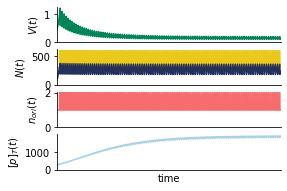

In [13]:
label_list = [r'$V(t)$', r'$N(t)$', r'$n_{ori}(t)$', r'$[p]_{T}(t)$']
x_axes_list = [time, time, time, time]
y_axes_list = [volume, number, n_oris, number/volume]
color_list = [green, dark_blue, pinkish_red, light_blue]
fig, ax = plt.subplots(len(label_list), figsize=(4,3))
plt.xlabel('time')
for item in range(0, len(label_list)):
    if item == 1:
        ax[item].plot(time, n_oris * n_crit, color=dark_yellow, zorder=2)
    ax[item].set_ylabel(label_list[item])
    ax[item].plot(x_axes_list[item], y_axes_list[item], color=color_list[item])
    ax[item].set_ylim(ymin=0)
    ax[item].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[item].spines["top"].set_visible(False)
    ax[item].spines["right"].set_visible(False)
    ax[item].margins(0)


plt.savefig(file_path + '/cell_cycle_'+division_control+'_'+gene_expr+'.pdf', format='pdf', bbox_inches='tight')

# Figure for SI 

new version for volume dependence:

In [15]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

t_b = np.array(list_t_div)
cycle_0 = 5
cycle_f = cycle_0 + 3
t_0 = t_b[cycle_0]
indx_0 = np.where(time==t_0)[0][0]
t_f = t_b[cycle_f]
indx_f = find_nearest_idx(time, t_f) + 20
n_s = n_oris * n_crit
total_conc = number/volume
t_init_arr = np.array(list_t_init)

n_ori_cut = n_oris[indx_0:indx_f]
time_cut = time[indx_0:indx_f]
volume_cut = volume[indx_0:indx_f]
n_ori_density_cut = n_ori_cut / volume_cut
n_p_cut = number[indx_0:indx_f]
n_s_cut = n_s[indx_0:indx_f]
total_conc_cut = total_conc[indx_0:indx_f]
t_init_list_cut_1 = t_init_arr[t_init_arr>t_0]
t_init_list_cut = t_init_list_cut_1[t_init_list_cut_1<t_f]
t_b_cut_1 = t_b[t_b<t_f]
t_b_cut = t_b_cut_1[t_b_cut_1 > t_0]
delta_t_init_th = (n_crit/2) / alpha 
delta_t_init = t_init_list_cut[1:]- t_init_list_cut[:-1]

old version for linear/bilinear:

In [19]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

t_0 = 0
indx_0 = np.where(time==t_0)[0][0]
t_f = 5*doubling_time 
t_f = np.array(list_t_div)[5]
indx_f = find_nearest_idx(time, t_f) + 20
n_s = n_oris * n_crit
total_conc = number/volume
t_init_arr = np.array(list_t_init)

n_ori_cut = n_oris[indx_0:indx_f]
time_cut = time[indx_0:indx_f]
volume_cut = volume[indx_0:indx_f]
n_ori_density_cut = n_ori_cut / volume_cut
n_p_cut = number[indx_0:indx_f]
n_s_cut = n_s[indx_0:indx_f]
total_conc_cut = total_conc[indx_0:indx_f]
t_init_list_cut_1 = t_init_arr[t_init_arr>t_0]
t_init_list_cut = t_init_list_cut_1[t_init_list_cut_1<t_f]
t_b = t_init_list_cut + t_cc
t_b_cut = t_b[t_b<t_f]
delta_t_init_th = (n_crit/2) / alpha 
delta_t_init = t_init_list_cut[1:]- t_init_list_cut[:-1]

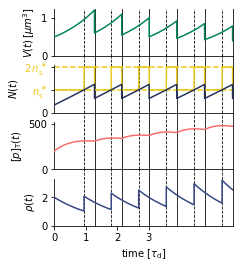

In [17]:
label_list = [r'$V(t) \, [\mu m^3]$', r'$N(t)$', r'$[p]_{\rm T}(t)$', r'$\rho(t)$']
x_axes_list = [time_cut, time_cut, time_cut, time_cut]
y_axes_list = [volume_cut, n_p_cut, total_conc_cut, n_ori_cut/volume_cut]
color_list = [green, dark_blue, pinkish_red, blue]
y_min_list = [0,0,0,0]
y_max_list = [1, 1.2, 1.2, 1.2]

fig, ax = plt.subplots(4, figsize=(3.2,4))
plt.xlabel(r'time [$\tau_{\rm d}$]')
for item in range(0, len(label_list)):
    if item == 1:
        ax[item].plot(time_cut, n_s_cut, color=dark_yellow, zorder=2)
    ax[item].set_ylabel(label_list[item])
    ax[item].plot(x_axes_list[item], y_axes_list[item], color=color_list[item], zorder=3)
    ax[item].set_ylim(ymin=0)
    ax[item].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[item].spines["top"].set_visible(False)
    ax[item].spines["right"].set_visible(False)
    ax[item].margins(0)
    for t_div in t_b_cut:
        ax[item].axvline(x=t_div, 
                          ymin=y_min_list[item],
                          ymax=y_max_list[item],
                             c="black",
                          zorder=0, 
                          linewidth=0.8,
                          clip_on=False)
    for t_init in t_init_list_cut:
        ax[item].axvline(x=t_init, 
                          ymin=y_min_list[item],
                          ymax=y_max_list[item],
                             c="black",
                          zorder=0, 
                          linewidth=0.8,
                          linestyle='--',
                          clip_on=False)
ax[0].set_yticks([0,1])
ax[0].set_yticklabels(['0','1'])
# ax[0].get_yticklabels()[2].set_color(color_list[0])
# ax[0].tick_params(axis='y', colors=green)
# ax[0].axhline(y=v_init, color=green, linestyle='--', label=r'$v^\ast$')
# ax[0].axhline(y=2*v_init, color=green, linestyle='--')


ax[1].set_yticks([0,n_crit, 2* n_crit])
ax[1].set_yticklabels(['0', r'$n_{\rm s}^\ast$', r'$2 \, n_{\rm s}^\ast$'])
# ax[1].set_yticks([0,n_crit, 2* n_crit, 4*n_crit])
# ax[1].set_yticklabels(['0', r'$n_{\rm s}^\ast$', r'$2 \, n_{\rm s}^\ast$', r'$4 \, n_{\rm s}^\ast$'])
# ax[1].get_yticklabels()[3].set_color(dark_yellow)
# ax[1].axhline(y=[4*n_crit], color=dark_yellow, linestyle='--')
ax[1].get_yticklabels()[1].set_color(dark_yellow)
ax[1].axhline(y=[n_crit], color=dark_yellow, linestyle='--')
ax[1].get_yticklabels()[2].set_color(dark_yellow)
ax[1].axhline(y=[2*n_crit], color=dark_yellow, linestyle='--')

ax[2].set(ylim=(0,total_conc_cut[-1]*1.1))

ax[3].tick_params(bottom=True, labelbottom=True)
ax[3].tick_params(axis='x', colors='black')

ax[3].set_xticks([time_cut[0], 
                  time_cut[0]+ doubling_time, 
                  time_cut[0]+ 2*doubling_time,
                  time_cut[0]+ 3*doubling_time
                 ])
ax[3].set_xticklabels(['0', '1', '2', '3'])
ax[3].margins(0)
ax[3].tick_params(     # ticks along the bottom edge are off
    bottom=True,         # ticks along the top edge are off
    labelbottom=True)

plt.savefig(file_path + '/S3_'+division_control+'_'+gene_expr+'.pdf', format='pdf', bbox_inches='tight')